In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# load dataset
data = read_csv('energydata_complete.csv', header=0, index_col=0)
print(data.head())
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

                        T3       RH_3         T4       RH_4    ...      \
date                                                           ...       
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667    ...       
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500    ...       
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000    ...       
2016-01-11 17:30:00  19.79  45.000000  18.890000  45.723333    ...       
2016-01-1

In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR
# Implementing VAR method
def VectorAutoRegression(data):
    #creating the train and validation set
    train = data[:int(0.8*(len(data)))]
    test = data[int(0.8*(len(data))):]
    print(len(test[:,0]))
    #fit the VAR model
    model = VAR(endog=train)
    model_fit = model.fit()
    prediction = model_fit.forecast(model_fit.y, steps=len(test))
    mae = mean_absolute_error(prediction[:,0], test[:,0])
    mse = mean_squared_error(prediction[:,0], test[:,0])
    return prediction[:,0], mse, mae, test[:,0]
    #fit the VARMA model
    """model = VARMAX(train, order=(1, 1))
    model_fit = model.fit()
    prediction = model_fit.forecast()
    MAE['VARMA'] = mean_absolute_error(prediction[0], test[0])
    MSE['VARMA'] = mean_squared_error(prediction[0], test[0])
    """

In [6]:
# convert time-series data to supervised data
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for j in range(0,n_vars):
        for i in range(n_in[j], 0, -1):
            cols.append(df[j].shift(i))
            names += [('var%d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
def split_data(data, n_lag, n_features,flag):
    n_obs = sum(n_lag)
    reframed = series_to_supervised(data, n_lag, 1)
    if flag==1 :
        print(reframed.head())
    # split into train and test sets
    values = reframed.values
    n_train = int(0.8*(len(data)))
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    #print(train_X.shape, len(train_X), train_y.shape)
    return train_X, train_y, test_X, test_y

In [8]:
# Implementing Linear Regression method
def LinearReg(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [9]:
# Implementing SVM method
def SVM_Gausian(data, n_lag, n_features,flag):
    # Fit SVM 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = SVR(kernel='rbf')
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [10]:
# Implementing SVM method
def SVM_Linear(data, n_lag, n_features,flag):
    # Fit SVM 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = SVR(kernel='linear')
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [11]:
# Implementing Lasso Regression method
def LassoRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Lasso()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [12]:
# Implementing Lasso Regression method
def RidgeRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Ridge()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [13]:
def LinearRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=LinearReg(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=LinearReg(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [14]:
def SVM_Gausian_PSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [15]:
def SVM_Linear_PSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [16]:
def LassoRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [17]:
def RidgeRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [18]:
def LinearRegGSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=LinearReg(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=LinearReg(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=LinearReg(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos


In [19]:
def SVM_Gausian_GSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos


In [20]:
def SVM_Linear_GSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos


In [50]:
def LassoRegGSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=LassoRegression(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos


In [22]:
def RidgeRegGSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos


In [23]:
# plot 2 lines
def plot(y1,y2,title,file_name):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted") 
    # naming the x axis 
    plt.xlabel('x - axis') 
    # naming the y axis 
    plt.ylabel('Appliance energy') 
    # giving a title to my graph 
    plt.title(title) 
    # show a legend on the plot 
    plt.legend() 
    # function to show the plot 
    
    plt.savefig(file_name,dpi=1200)
    plt.show()

In [24]:
MSE = {}
MAE = {}


3947


C:\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


MSE for VAR method: 0.007211959691707641
MAE for VAR method: 0.0485715465229016


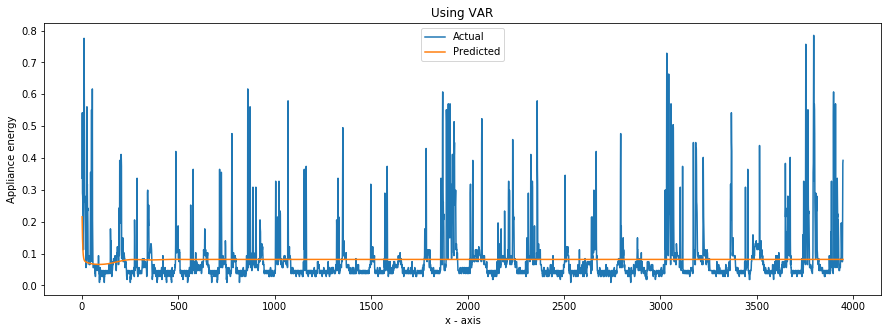

In [25]:
# Call VAR model
prediction, MSE['VAR'], MAE['VAR'], test = VectorAutoRegression(scaled)
print("MSE for VAR method: " + str(MSE['VAR']))
print("MAE for VAR method: " + str(MAE['VAR']))
plot(test, prediction, 'Using VAR','VAR.png')

   var1(t-2)  var1(t-1)  var2(t-3)  var2(t-2)  var2(t-1)  var3(t-2)  \
3   0.046729   0.037383   0.428571   0.428571   0.428571   0.327349   
4   0.037383   0.037383   0.428571   0.428571   0.571429   0.327349   
5   0.037383   0.046729   0.428571   0.571429   0.571429   0.327349   
6   0.046729   0.037383   0.571429   0.571429   0.571429   0.327349   
7   0.037383   0.046729   0.571429   0.571429   0.714286   0.327349   

   var3(t-1)  var4(t-3)  var4(t-2)  var4(t-1)    ...     var19(t)  var20(t)  \
3   0.327349   0.566187   0.541326   0.530502    ...     0.219563  0.671909   
4   0.327349   0.541326   0.530502   0.524080    ...     0.219563  0.671909   
5   0.327349   0.530502   0.524080   0.531419    ...     0.219563  0.667356   
6   0.327349   0.524080   0.531419   0.522980    ...     0.219563  0.667356   
7   0.327349   0.531419   0.522980   0.515824    ...     0.219563  0.667356   

   var21(t)  var22(t)  var23(t)  var24(t)  var25(t)  var26(t)  var27(t)  \
3  0.361736  0.104652  

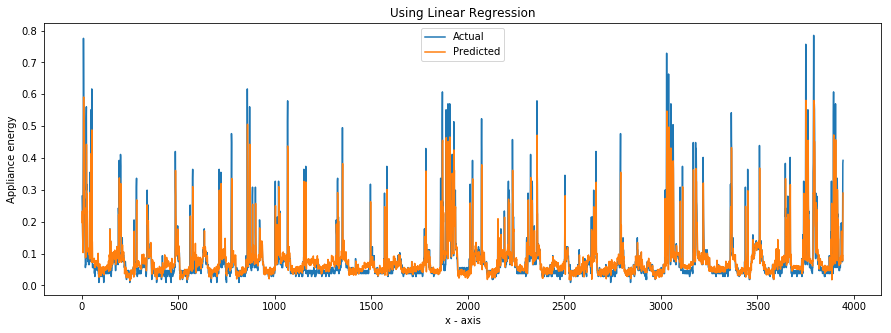

In [26]:
# Call Linear Regression model
n_lag = []
n_features = 28
for i in range(0,n_features):
    if i%2==0:
        n_lag.append(2)
    else:
        n_lag.append(3)
prediction, MSE['LinearRegression'], MAE['LinearRegression'], test = LinearReg(scaled, n_lag, n_features,1)
print("MSE for Linear Regression method: " + str(MSE['LinearRegression']))
print("MAE for Linear Regression method: " + str(MAE['LinearRegression']))
plot(test, prediction, 'Using Linear Regression','Linear Regression.png')

MSE for SVM_Gausian method: 0.00757482115522261
MAE for SVM_Gausian method: 0.07872774685449496


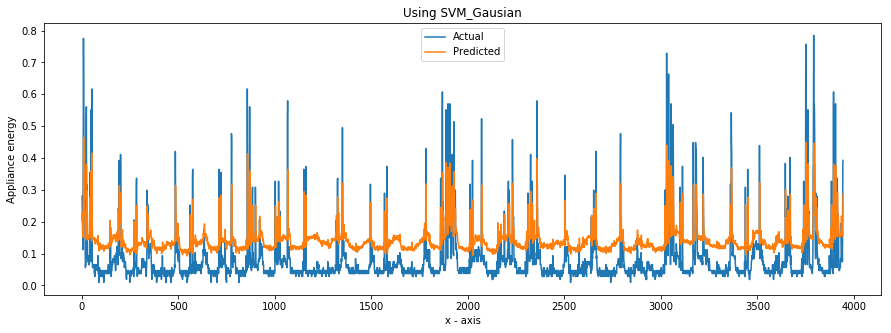

In [27]:
# Call SVM Gausian model
prediction, MSE['SVM_Gausian'], MAE['SVM_Gausian'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian method: " + str(MSE['SVM_Gausian']))
print("MAE for SVM_Gausian method: " + str(MAE['SVM_Gausian']))
plot(test, prediction, 'Using SVM_Gausian','SVM_Gausian.png')

MSE for SVM_Linear method: 0.006942378427962659
MAE for SVM_Linear method: 0.07382870633062541


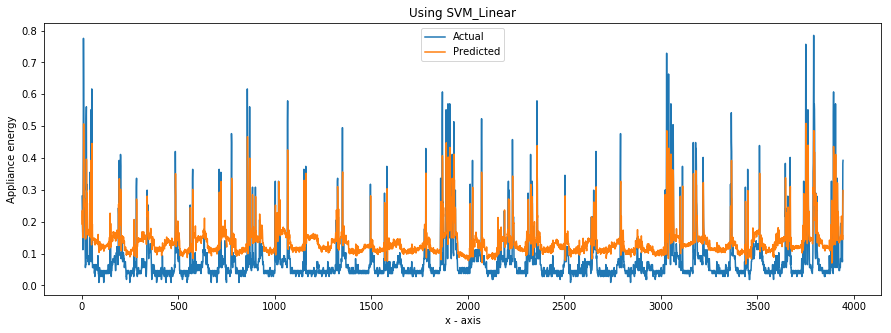

In [28]:
# Call SVM Linear model
prediction, MSE['SVM_Linear'], MAE['SVM_Linear'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear method: " + str(MSE['SVM_Linear']))
print("MAE for SVM_Linear method: " + str(MAE['SVM_Linear']))
plot(test, prediction, 'Using SVM_Linear','SVM_Linear.png')

MSE for Lasso Regression method: 0.007166294
MAE for Lasso Regression method: 0.049073108


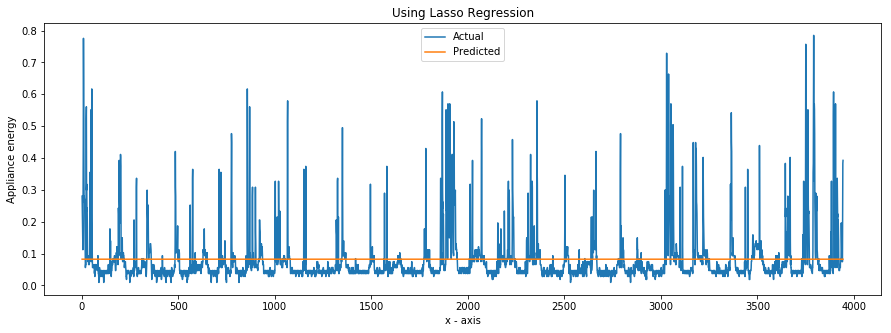

In [29]:
# Call Lasso Regression model
prediction, MSE['LassoRegression'], MAE['LassoRegression'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression method: " + str(MSE['LassoRegression']))
print("MAE for Lasso Regression method: " + str(MAE['LassoRegression']))
plot(test, prediction, 'Using Lasso Regression','Lasso Regression.png')

MSE for Ridge Regression method: 0.0032721302
MAE for Ridge Regression method: 0.027116172


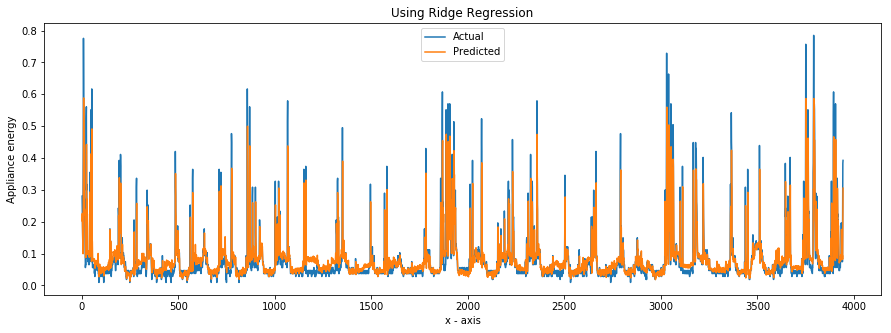

In [30]:
# Call Ridge Regression model
prediction, MSE['RidgeRegression'], MAE['RidgeRegression'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression method: " + str(MSE['RidgeRegression']))
print("MAE for Ridge Regression method: " + str(MAE['RidgeRegression']))
plot(test, prediction, 'Using Ridge Regression','Ridge Regression.png')

In [31]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Linear regression PSO call
mse, n_lag = LinearRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)


USING PSO
int32
Iteration: 1 ; Bestposition = [10  1  9 14  8 20  1 20 10  1  6  1  4  1 20 20  5  7  9 12  2 20  9  1
  1 10  1 20]  Bestcost = 0.0031241432
Iteration: 2 ; Bestposition = [10  1  9 14  8 20  1 20 10  1  6  1  4  1 20 20  5  7  9 12  2 20  9  1
  1 10  1 20]  Bestcost = 0.0031241432
Iteration: 3 ; Bestposition = [10  1  9 14  8 20  1 20 10  1  6  1  4  1 20 20  5  7  9 12  2 20  9  1
  1 10  1 20]  Bestcost = 0.0031241432
Iteration: 4 ; Bestposition = [10  1  9 20  4 20  1 20 20  1  2  1  2  1 20 20  6  3 11 20  2 20  5  1
  1 10  1 20]  Bestcost = 0.003122256
Iteration: 5 ; Bestposition = [10  1  9 20  1 20  1 20 11  1  4  1  1  1 20 20  9  1  1 20  3 20  1  1
  1  7  1 20]  Bestcost = 0.0031174596
Iteration: 6 ; Bestposition = [10  1  9 20  1 20  1 20  6  1  4  1  1  1 20 20  9  1  1 20  4 20  1  1
  1  2  1 20]  Bestcost = 0.0031073545
Iteration: 7 ; Bestposition = [16  1  8 20  1 20  1 20  1  1  3  1  1  1 20 20  8  1  1 20  1 20  1  1
  1  1  1 20]  Bestcost = 0.0

MSE for Linear Regression with PSO method: 0.0031025277
MAE for Linear Regression with PSO method: 0.02756487


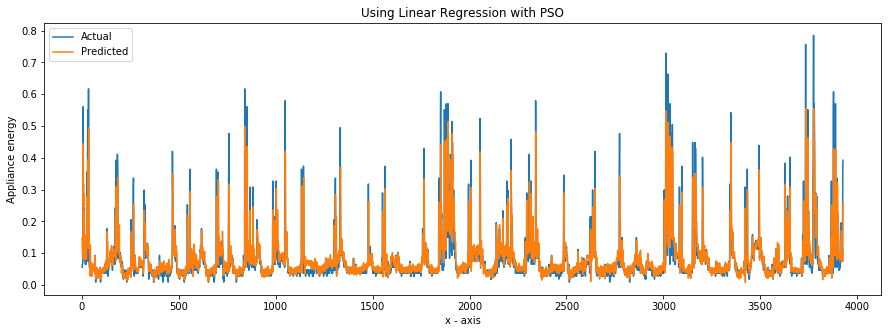

In [32]:
# Use Result from Linear Regression with PSO method
prediction, MSE['LinearRegPSO'], MAE['LinearRegPSO'], test = LinearReg(scaled, n_lag, n_features,0)
print("MSE for Linear Regression with PSO method: " + str(MSE['LinearRegPSO']))
print("MAE for Linear Regression with PSO method: " + str(MAE['LinearRegPSO']))
plot(test, prediction, 'Using Linear Regression with PSO','Linear Regression with PSO.png')

In [33]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Call SVM-Gausian-PSO method
mse, n_lag = SVM_Gausian_PSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)


USING PSO
int32
Iteration: 1 ; Bestposition = [16  1 13 15 19  1 19  1  4  5  4 11  7 19 20  2 15 19 17  1 11 19 10  6
  1  5 10  8]  Bestcost = 0.007654834821014946
Iteration: 2 ; Bestposition = [16  1 19 14 20  1 20  1  1  1  5  8  4 20 20  1 19 20 15  1 12 20 11  7
  1  8  6  1]  Bestcost = 0.007506684421196761
Iteration: 3 ; Bestposition = [16  1 20 13 20  1 20  1  1  1  6  5  1 20 20  1 20 20 13  1 13 20 12  8
  1 11  2  1]  Bestcost = 0.007405457590421738
Iteration: 4 ; Bestposition = [16  1 20 13 20  1 20  1  1  1  6  5  1 20 20  1 20 20 13  1 13 20 12  8
  1 11  2  1]  Bestcost = 0.007405457590421738
Iteration: 5 ; Bestposition = [20  1 20 15 20  1 20  1  1  1  2  6  1 20 20  1 20 20  5  4 16 20  3  8
 16 16  2  1]  Bestcost = 0.007337287760202254
Iteration: 6 ; Bestposition = [20  1 20 20 20  1 20  1  1  1 12  7  1 20 20  1 20 20  1  1  8 20  5  3
  1 14  1  1]  Bestcost = 0.007291328035750249
Iteration: 7 ; Bestposition = [20  1 20 20 20  1 20  1  1  1 12  7  1 20 20  1 20 2

MSE for SVM_Gausian with PSO method: 0.0071372154328768105
MAE for SVM_Gausian with PSO method: 0.0755747088175853


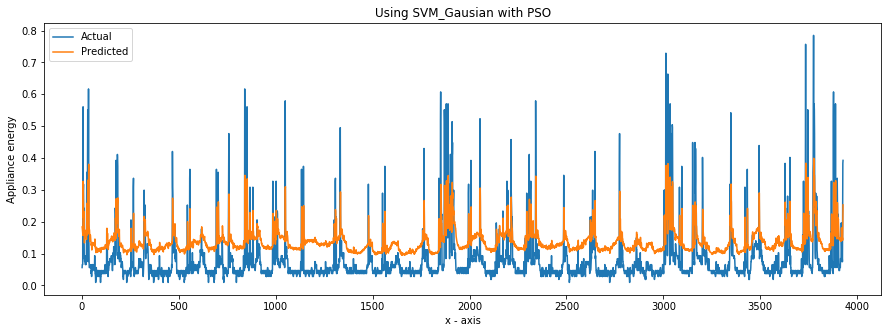

In [34]:
# Use Result from SVM-Gausian with PSO method
prediction, MSE['SVM_Gausian_PSO'], MAE['SVM_Gausian_PSO'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian with PSO method: " + str(MSE['SVM_Gausian_PSO']))
print("MAE for SVM_Gausian with PSO method: " + str(MAE['SVM_Gausian_PSO']))
plot(test, prediction, 'Using SVM_Gausian with PSO','SVM_Gausian_PSO.png')


USING PSO
int32
Iteration: 1 ; Bestposition = [ 7 18 17 10 13 15 16 18 13 20  1 18  9 20 14 20  4  6  5 12  9  1  8  6
 20 20 13  1]  Bestcost = 0.0061066853821413756
Iteration: 2 ; Bestposition = [ 5 20 20 20 11 20 13 20 13 20  1 19  3 20  1 20  4  1 18 15  5  1  4  1
 13 20 20 10]  Bestcost = 0.006099506385402814
Iteration: 3 ; Bestposition = [ 5 20 20 20 11 20 13 20 13 20  1 19  3 20  1 20  4  1 18 15  5  1  4  1
 13 20 20 10]  Bestcost = 0.006099506385402814
Iteration: 4 ; Bestposition = [ 5 20 20 20 11 20 13 20 13 20  1 19  3 20  1 20  4  1 18 15  5  1  4  1
 13 20 20 10]  Bestcost = 0.006099506385402814
Iteration: 5 ; Bestposition = [ 9 18 18 20  7 20 14 20 20 20  1 19  8 20  1 20  7  1 11  5  4  1 10  7
 17 20 20  1]  Bestcost = 0.006026154812565228
Iteration: 6 ; Bestposition = [ 8 17 16 20 12 20 17 20 20 20  1 18  8 20  1 20 13  1  2  5  1  1 15 12
 14 20 20  1]  Bestcost = 0.005928540315625225
Iteration: 7 ; Bestposition = [ 8 17 16 20 12 20 17 20 20 20  1 18  8 20  1 20 13 

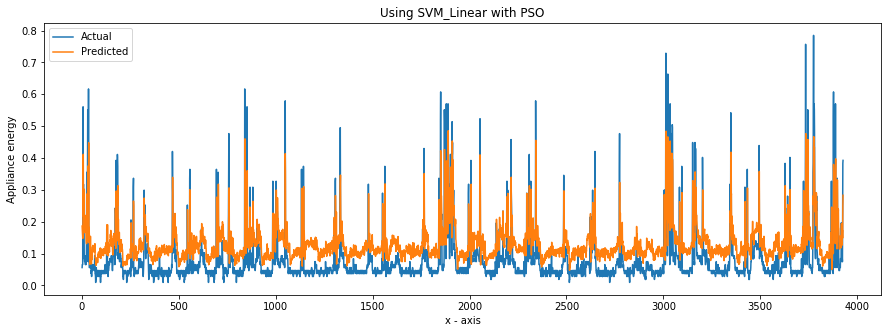

In [35]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Call SVM-Linear-PSO method
mse, n_lag = SVM_Linear_PSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from SVM-Linear with PSO method
prediction, MSE['SVM_Linear_PSO'], MAE['SVM_Linear_PSO'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear with PSO method: " + str(MSE['SVM_Linear_PSO']))
print("MAE for SVM_Linear with PSO method: " + str(MAE['SVM_Linear_PSO']))
plot(test, prediction, 'Using SVM_Linear with PSO','SVM_Linear_PSO.png')


USING PSO
int32
Iteration: 1 ; Bestposition = [ 1  5 20  2 14  8  1  4  1 11  6  6 12 11 12 14  4  2  6  8  3 20  6  7
  1  8  9 12]  Bestcost = 0.0068656425
Iteration: 2 ; Bestposition = [ 1  1 20  1 11 11  1  3  1  1  6 14 13  7 20 20  4  1  1 13  1 20  9  6
  1  2 17 16]  Bestcost = 0.0068656425
Iteration: 3 ; Bestposition = [ 1  1 20  1  9 11  1  4  1  1  6 17 14  8 20 20  4  1  1 12  1 20 12  6
  1 11 20 18]  Bestcost = 0.0068656425
Iteration: 4 ; Bestposition = [ 1  1 20  1 12  9  1  5  2  1  6  7 15 14 20 20  4  1  7  3 11 20 11  8
  1 18 20 13]  Bestcost = 0.0068656425
Iteration: 5 ; Bestposition = [ 1  1 20  5 16  5  1  6  4  1  6  1 13 19 20 20  4  1 13  1 19 20  4 10
  1 20 14 10]  Bestcost = 0.0068656425
Iteration: 6 ; Bestposition = [ 1  1 20  8 14  4  1  6  6  1  6  8 11 18 20 20  4  1 16  5  7 20  5  9
  1 20 10 11]  Bestcost = 0.0068656425
Iteration: 7 ; Bestposition = [ 1  1 20  8 11  5  1  4  7  2  6 16 10 17 20 20  4  1  7  9  1 20  7  6
  1  5  8 15]  Bestcost = 0.

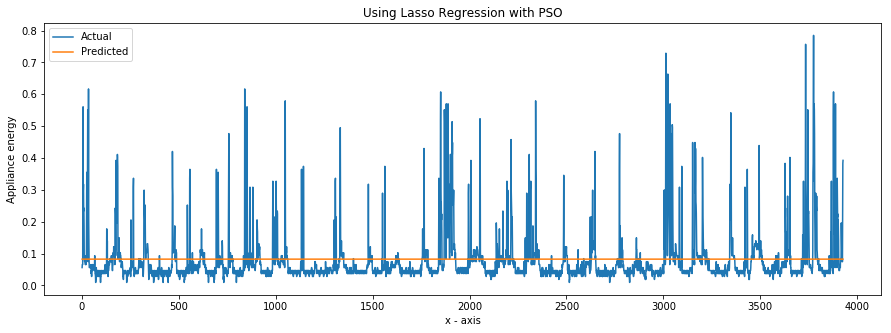

In [36]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Lasso regression PSO call
mse, n_lag = LassoRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from Lasso Regression with PSO method
prediction, MSE['LassoRegPSO'], MAE['LassoRegPSO'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression with PSO method: " + str(MSE['LassoRegPSO']))
print("MAE for Lasso Regression with PSO method: " + str(MAE['LassoRegPSO']))
plot(test, prediction, 'Using Lasso Regression with PSO','Lasso Regression with PSO.png')


USING PSO
int32
Iteration: 1 ; Bestposition = [20 15  5  4 16 20 18 12  3  9 15  8  6 10  4  6 13  3 19 20  8 20 10  1
 11 20  4  1]  Bestcost = 0.0030891239
Iteration: 2 ; Bestposition = [20 15  5  4 16 20 18 12  3  9 15  8  6 10  4  6 13  3 19 20  8 20 10  1
 11 20  4  1]  Bestcost = 0.0030891239
Iteration: 3 ; Bestposition = [20 14  1  1 20 20 20  1  6  1 20 10  1 20  5  1 14  1 20 20 18 20  3  1
 20 20  1  1]  Bestcost = 0.003079368
Iteration: 4 ; Bestposition = [20 16  1  1 20 20 20  1  1 11 20  5  1 20  1  1  6  1 20 20  8 20  1  1
 20 20  1  1]  Bestcost = 0.0030761429
Iteration: 5 ; Bestposition = [20  8  1  1 20 20 20  1  1 10 20  1  1 20  1  1 20  1 20 20  9 20  1  1
 20 20  1  1]  Bestcost = 0.0030729203
Iteration: 6 ; Bestposition = [20  9  1  1 20 20 20  1  1 20 20  1  1 20  1  1 20  1 20 20  9 20  1  1
 20 20  1  1]  Bestcost = 0.0030704034
Iteration: 7 ; Bestposition = [20  9  1  1 20 20 20  1  1 20 20  1  1 20  1  1 20  1 20 20  9 20  1  1
 20 20  1  1]  Bestcost = 0.0

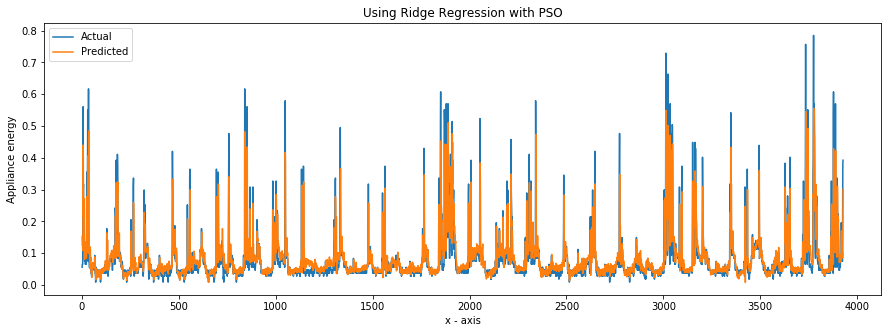

In [37]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Lasso regression PSO call
mse, n_lag = RidgeRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from Lasso Regression with PSO method
prediction, MSE['RidgeRegPSO'], MAE['RidgeRegPSO'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression with PSO method: " + str(MSE['RidgeRegPSO']))
print("MAE for Ridge Regression with PSO method: " + str(MAE['RidgeRegPSO']))
plot(test, prediction, 'Using Ridge Regression with PSO','Ridge Regression with PSO.png')


USING GSA
Iteration: 0 ; Bestposition = [16 13 17 18 16 14 17  2  5  5 16 17 10 13 15 13 14  3 14 15  1  4 10 17
  4  3 18  5]  Bestcost = 0.003133907
Iteration: 1 ; Bestposition = [15 12 16 17 15 13 16  1  4  5 15 16 10 13 15 13 14  3 14 15  1  4 10 17
  4  3 17  5]  Bestcost = 0.003120285
Iteration: 2 ; Bestposition = [15 12 16 17 15 13 16  1  4  5 15 16 10 13 15 13 14  3 14 15  1  4 10 17
  4  3 17  5]  Bestcost = 0.003120285
Iteration: 3 ; Bestposition = [13 10 14 15 13 11 14  1  3  5 13 14  8 11 13 11 12  3 12 13  1  3  9 15
  4  2 15  5]  Bestcost = 0.003117964
Iteration: 4 ; Bestposition = [12  9 13 14 12 10 13  1  3  5 12 13  7 10 12 10 11  3 11 12  1  2  9 14
  4  2 14  5]  Bestcost = 0.003109848
Iteration: 5 ; Bestposition = [12  9 13 14 12 10 13  1  3  5 12 13  7 10 12 10 11  3 11 12  1  2  9 14
  4  2 14  5]  Bestcost = 0.003109848
Iteration: 6 ; Bestposition = [12  9 13 14 12 10 13  1  3  5 12 13  7 10 12 10 11  3 11 12  1  2  9 14
  4  2 14  5]  Bestcost = 0.003109848
It

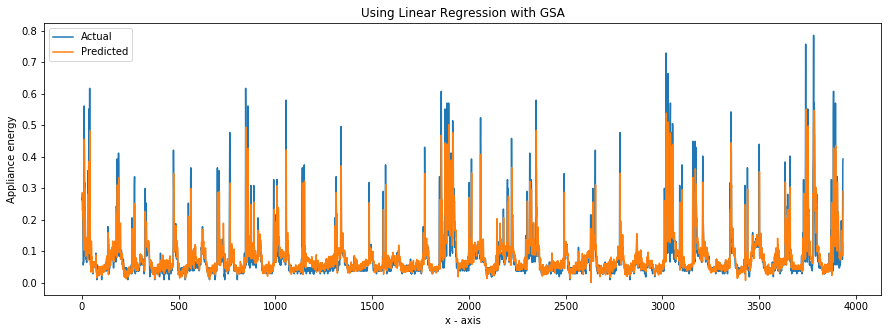

In [38]:
# GSA Parameters
import sys
m=20
maxI=10
npop=5
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call Linear Regression GSA method
mse, n_lag = LinearRegGSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from Linear Regression with GSA method
prediction, MSE['LinearRegGSA'], MAE['LinearRegGSA'], test = LinearReg(scaled, n_lag, n_features,0)
print("MSE for Linear Regression with GSA method: " + str(MSE['LinearRegGSA']))
print("MAE for Linear Regression with GSA method: " + str(MAE['LinearRegGSA']))
plot(test, prediction, 'Using Linear Regression with GSA','Linear Regression with GSA.png')


USING GSA


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


Iteration: 0 ; Bestposition = [ 8 12 14  9 13 15 14  8 17 17 13 18 17 11 18  2 12 10 15 17 18 11 10  9
 16 19  4  4]  Bestcost = 0.008107895520556631
MSE for SVM_Gausian with GSA method: 0.008107895520556631
MAE for SVM_Gausian with GSA method: 0.0819284599568961


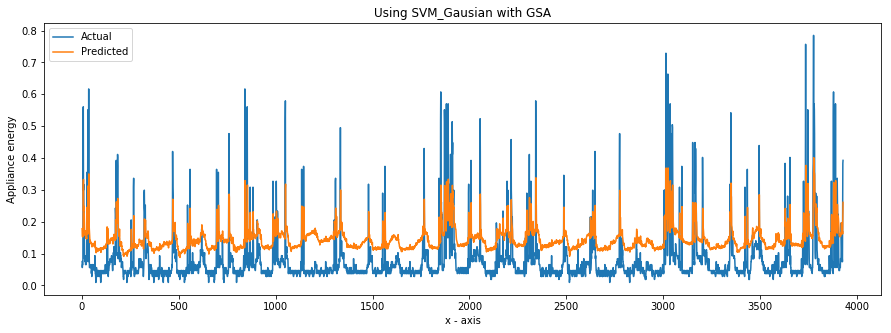

In [39]:
# GSA Parameters
m=20
maxI=1
npop=1
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call SVM Gausian GSA method
mse, n_lag = SVM_Gausian_GSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from SVM-Gausian with GSA method
prediction, MSE['SVM_Gausian_GSA'], MAE['SVM_Gausian_GSA'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian with GSA method: " + str(MSE['SVM_Gausian_GSA']))
print("MAE for SVM_Gausian with GSA method: " + str(MAE['SVM_Gausian_GSA']))
plot(test, prediction, 'Using SVM_Gausian with GSA','SVM_Gausian_GSA.png')


USING GSA


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


Iteration: 0 ; Bestposition = [ 6 14 15  1 17 16  2  7 10  4  7  9 14 18  5 17 10 18  7 17 16 16  3 10
 13  9 16 18]  Bestcost = 0.0063938296481731395
MSE for SVM_Linear with GSA method: 0.0063938296481731395
MAE for SVM_Linear with GSA method: 0.06974639579163236


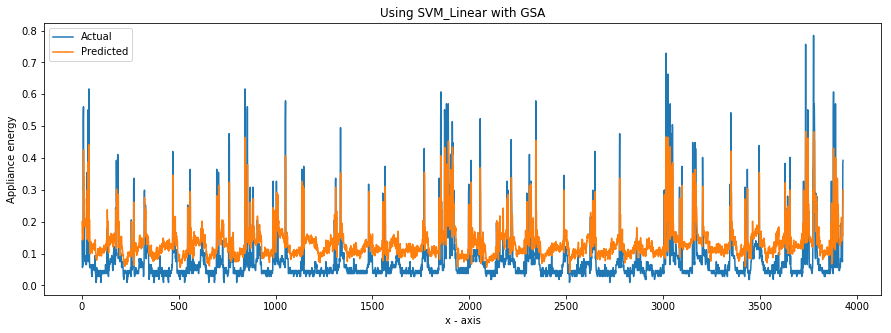

In [40]:
# GSA Parameters
m=20
maxI=1
npop=1
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call SVM Linear GSA method
mse, n_lag = SVM_Linear_GSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from SVM-Linear with GSA method
prediction, MSE['SVM_Linear_GSA'], MAE['SVM_Linear_GSA'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear with GSA method: " + str(MSE['SVM_Linear_GSA']))
print("MAE for SVM_Linear with GSA method: " + str(MAE['SVM_Linear_GSA']))
plot(test, prediction, 'Using SVM_Linear with GSA','SVM_Linear_GSA.png')


USING GSA
Iteration: 0 ; Bestposition = [ 1 12  1  1 14 12 12 12  7 15 13 12  3  8 12  9  1  1 15 12 18 10  8  7
  8 14  9 16]  Bestcost = 0.0068656425
Iteration: 1 ; Bestposition = [ 1 12  1  1 14 12 12 12  7 15 13 12  3  8 12  9  1  1 15 12 18 10  8  7
  8 14  9 16]  Bestcost = 0.0068656425
Iteration: 2 ; Bestposition = [ 1 12  1  1 14 12 12 12  7 15 13 12  3  8 12  9  1  1 15 12 18 10  8  7
  8 14  9 16]  Bestcost = 0.0068656425
Iteration: 3 ; Bestposition = [ 1 12  1  1 14 12 12 12  7 15 13 12  3  8 12  9  1  1 15 12 18 10  8  7
  8 14  9 16]  Bestcost = 0.0068656425
Iteration: 4 ; Bestposition = [ 1 12  1  1 14 12 12 12  7 15 13 12  3  8 12  9  1  1 15 12 18 10  8  7
  8 14  9 16]  Bestcost = 0.0068656425
MSE for Lasso Regression with GSA method: 0.0068656425
MAE for Lasso Regression with GSA method: 0.048450407


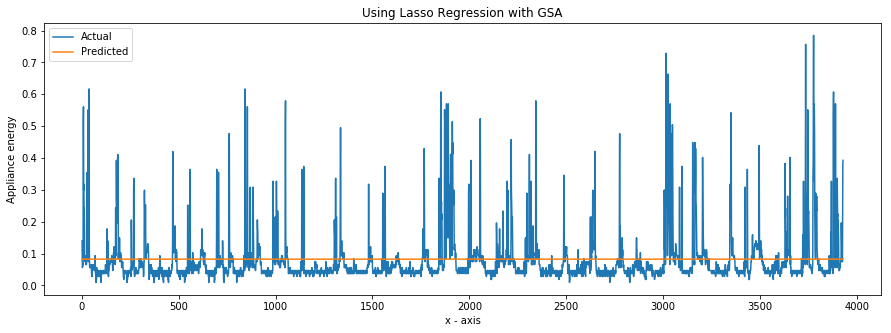

In [51]:
# GSA Parameters
import sys
m=20
maxI=5
npop=2
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call Lasso Regression GSA method
mse, n_lag = LassoRegGSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from Lasso Regression with GSA method
prediction, MSE['LassoRegGSA'], MAE['LassoRegGSA'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression with GSA method: " + str(MSE['LassoRegGSA']))
print("MAE for Lasso Regression with GSA method: " + str(MAE['LassoRegGSA']))
plot(test, prediction, 'Using Lasso Regression with GSA','Lasso Regression with GSA.png')


USING GSA
Iteration: 0 ; Bestposition = [ 7 11 14  4  8  7 12 17 12 10  7  2 12 10  8 18  4 12 12 15 12 11  9 10
  5  3 10  5]  Bestcost = 0.003117075
Iteration: 1 ; Bestposition = [ 6 10 13  4  7  6 11 16 11  9  6  2 12 10  7 17  4 11 11 14 11 10  9 10
  5  3 10  4]  Bestcost = 0.003114282
Iteration: 2 ; Bestposition = [ 6 10 13  4  7  6 11 16 11  9  6  2 12 10  7 17  4 11 11 14 11 10  9 10
  5  3 10  4]  Bestcost = 0.003114282
Iteration: 3 ; Bestposition = [ 4  2  4  7  3  8  9  6 14  4  6 15  3  7  2 15 11  7 10  5  8 12 15  8
 11 13 15  4]  Bestcost = 0.0031121625
Iteration: 4 ; Bestposition = [ 4  2  4  7  3  8  9  6 14  4  6 15  3  7  2 15 11  7 10  5  8 12 15  8
 11 13 15  4]  Bestcost = 0.0031121625
Iteration: 5 ; Bestposition = [ 4  2  4  7  3  8  9  6 14  4  6 15  3  7  2 15 11  7 10  5  8 12 15  8
 11 13 15  4]  Bestcost = 0.0031121625
Iteration: 6 ; Bestposition = [ 4  2  4  7  3  8  9  6 14  4  6 15  3  7  2 15 11  7 10  5  8 12 15  8
 11 13 15  4]  Bestcost = 0.003112162

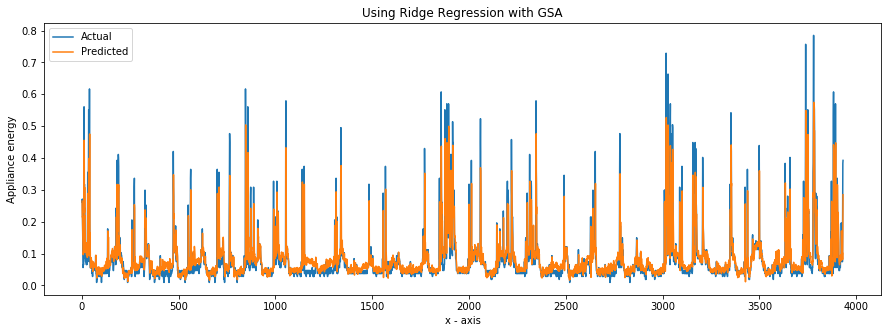

In [46]:
# GSA Parameters
import sys
m=20
maxI=10
npop=5
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call Ridge Regression GSA method
mse, n_lag = RidgeRegGSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from Ridge Regression with GSA method
prediction, MSE['RidgeRegGSA'], MAE['RidgeRegGSA'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression with GSA method: " + str(MSE['RidgeRegGSA']))
print("MAE for Ridge Regression with GSA method: " + str(MAE['RidgeRegGSA']))
plot(test, prediction, 'Using Ridge Regression with GSA','Ridge Regression with GSA.png')

In [65]:
methods = ["LinearRegression","SVM_Gausian","SVM_Linear","LassoRegression","RidgeRegression","LinearRegPSO","SVM_Gausian_PSO","SVM_Linear_PSO","LassoRegPSO","RidgeRegPSO","LinearRegGSA","SVM_Gausian_GSA","SVM_Linear_GSA","LassoRegGSA","RidgeRegGSA","VAR"]
print(methods)
print(MSE)

['LinearRegression', 'SVM_Gausian', 'SVM_Linear', 'LassoRegression', 'RidgeRegression', 'LinearRegPSO', 'SVM_Gausian_PSO', 'SVM_Linear_PSO', 'LassoRegPSO', 'RidgeRegPSO', 'LinearRegGSA', 'SVM_Gausian_GSA', 'SVM_Linear_GSA', 'LassoRegGSA', 'RidgeRegGSA', 'VAR']
{'VAR': 0.007211959691707641, 'LinearRegression': 0.0032754058, 'SVM_Gausian': 0.00757482115522261, 'SVM_Linear': 0.006942378427962659, 'LassoRegression': 0.007166294, 'RidgeRegression': 0.0032721302, 'LinearRegPSO': 0.0031025277, 'SVM_Gausian_PSO': 0.0071372154328768105, 'SVM_Linear_PSO': 0.005919580193212931, 'LassoRegPSO': 0.006868287, 'RidgeRegPSO': 0.0030672373, 'LinearRegGSA': 0.003109848, 'SVM_Gausian_GSA': 0.008107895520556631, 'SVM_Linear_GSA': 0.0063938296481731395, 'RidgeRegGSA': 0.0031121625, 'LassoRegGSA': 0.0068656425}


In [66]:
print(MAE)

{'VAR': 0.0485715465229016, 'LinearRegression': 0.027351558, 'SVM_Gausian': 0.07872774685449496, 'SVM_Linear': 0.07382870633062541, 'LassoRegression': 0.049073108, 'RidgeRegression': 0.027116172, 'LinearRegPSO': 0.02756487, 'SVM_Gausian_PSO': 0.0755747088175853, 'SVM_Linear_PSO': 0.06631068271833744, 'LassoRegPSO': 0.048459273, 'RidgeRegPSO': 0.026752643, 'LinearRegGSA': 0.02780106, 'SVM_Gausian_GSA': 0.0819284599568961, 'SVM_Linear_GSA': 0.06974639579163236, 'RidgeRegGSA': 0.026778001, 'LassoRegGSA': 0.048450407}


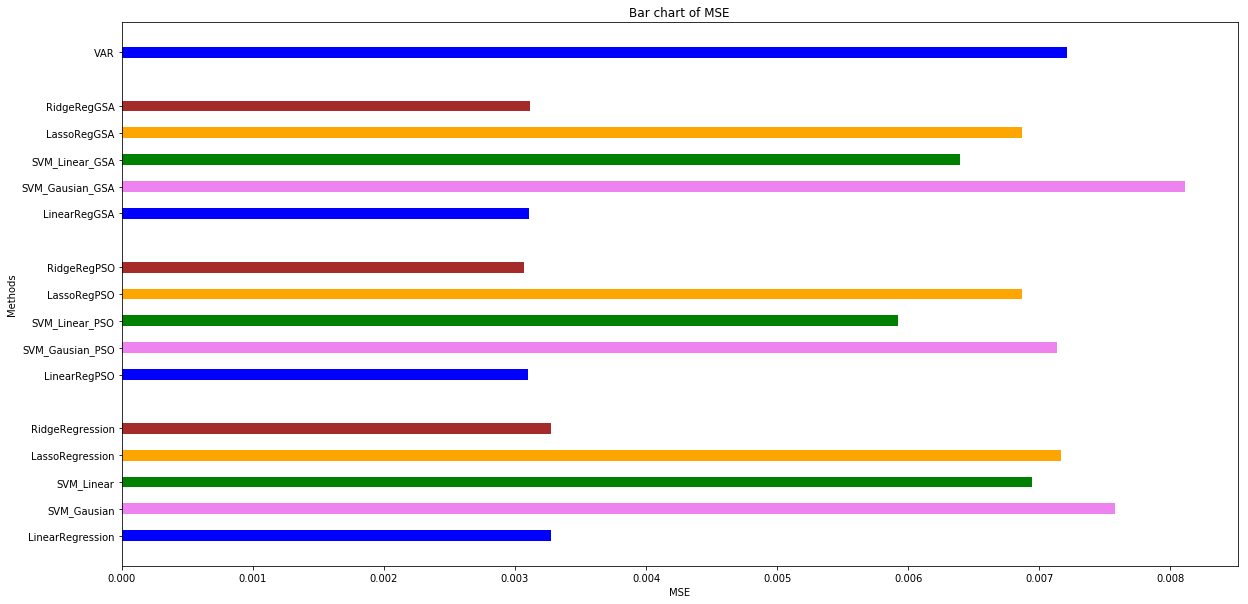

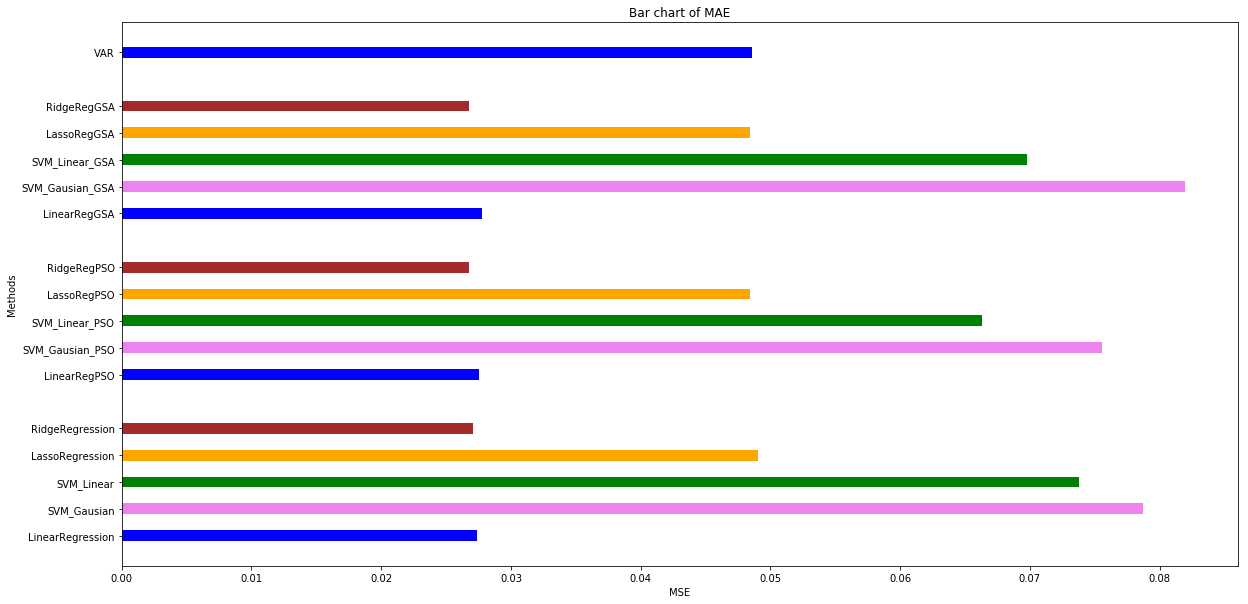

In [70]:
performance = []
for i in range(0,16):
    performance.append(MSE[methods[i]])
    

# x-coordinates of left sides of bars  
left = [1, 3, 5, 7 , 9, 13, 15, 17, 19, 21, 25, 27, 29, 31, 33, 37] 
# plotting a bar chart 
plt.rcParams['figure.figsize'] = [20, 10]
plt.barh(left, performance, tick_label = methods, color = ['blue', 'violet', 'green', 'orange', 'brown']) 
  
# naming the y-axis 
plt.ylabel('Methods') 
# naming the x-axis 
plt.xlabel('MSE') 
# plot title 
plt.title('Bar chart of MSE') 
# function to show the plot 
plt.savefig('MSE.png',dpi=1200)
plt.show() 





for i in range(0,16):
    performance[i]=MAE[methods[i]]
# plotting a bar chart 
plt.rcParams['figure.figsize'] = [20, 10]
plt.barh(left, performance, tick_label = methods, color = ['blue', 'violet', 'green', 'orange', 'brown']) 
# naming the y-axis 
plt.ylabel('Methods') 
# naming the x-axis 
plt.xlabel('MSE') 
# plot title 
plt.title('Bar chart of MAE') 
# function to show the plot
plt.savefig('MAE.png',dpi=1200)
plt.show() 